In [134]:
import torch
from torch import nn
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
sys.path.append(os.path.join(os.getcwd(), ".."))

In [14]:
data_train = pd.read_csv(os.path.join("..", "data", "revalidated", "data_train_f_001.csv"))
data_train.head()

,path,label,conf,revalidated_manually
0,.\data\train\subject-1\fall\1_backward_falls\f...,0,0.000000,1
1,.\data\train\subject-1\fall\1_backward_falls\f...,0,0.000000,1
2,.\data\train\subject-1\fall\1_backward_falls\f...,1,0.444923,1
3,.\data\train\subject-1\fall\1_backward_falls\f...,1,0.616470,1
4,.\data\train\subject-1\fall\1_backward_falls\f...,0,0.000000,1


In [9]:
from transformer import PoseKeypointsTransformer
transformer = PoseKeypointsTransformer(with_visibility=False)

In [19]:
keypoints_list = transformer(image_paths=data_train.iloc[:, 0].values)

In [22]:
torch.save(keypoints_list, os.path.join("..", "data", "keypoints", "keypoints_tensor.pt"))

In [52]:
list_of_tensors = torch.load(os.path.join("..", "data", "keypoints", "keypoints_tensor.pt"))

max_keypoints = 99
padded_keypoints = []
masks = []

for tensor in list_of_tensors:
    mask = torch.ones(max_keypoints)  
    
    if tensor.size(0) < max_keypoints:
        padding = torch.zeros(max_keypoints - tensor.size(0), dtype=torch.float32)
        tensor = torch.cat([tensor, padding], dim=0)
        mask[tensor.size(0):] = 0  
    
    padded_keypoints.append(tensor)
    masks.append(mask)

keypoints_tensor = torch.stack(padded_keypoints, dim=0)
mask_tensor = torch.stack(masks, dim=0)
labels = torch.tensor(data_train['label'].values)

C:\Users\tsfai\AppData\Local\Temp\ipykernel_32276\266390309.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  list_of_tensors = torch.load(os.path.join("..", "data", "keyp

In [55]:
from torch.utils.data import DataLoader, TensorDataset, random_split

dataset = TensorDataset(keypoints_tensor, labels)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")

Train dataset size: 3435
Validation dataset size: 859


In [129]:
class FallDetectionModel(nn.Module):
    def __init__(self, input_size, hidden_size=128):
        super(FallDetectionModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 64)
        self.fc3 = nn.Linear(64, 1)  
        self.sigmoid = nn.Sigmoid()  

    def forward(self, x):
        x = torch.relu(self.fc1(x))  
        x = torch.relu(self.fc2(x))  
        x = self.fc3(x)
        x = self.sigmoid(x)  
        return x
    
def train(model, train_loader, val_loader, optimizer, criterion, scheduler, epochs=100, make_history=False):
    model.train()
    history = []
    for epoch in range(1, epochs+1):
        running_loss = 0.0
        
        for inputs, labels in train_loader:
            labels = labels.float()
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
    
        if (epoch) % 5 == 0:
            result_text = f"Epoch {epoch}/{epochs}, Train Loss: {running_loss / len(train_loader)}"
        
            if scheduler is not None:
                val_acc, val_loss = evaluate(model, val_loader, criterion, ret=True, silence=True)
                result_text += f"Val Loss: {val_loss}, Val Accuracy: {val_acc}"

                if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                    scheduler.step(val_loss)
                else:
                    scheduler.step()

            print(result_text)

            if make_history:
                history.append((running_loss/len(train_loader), val_loss))

    if make_history:
        return history
        

def evaluate(model, test_loader, criterion=None, threshold=0.75, ret=False, silence=False):
    model.eval()
    correct = 0
    total = 0
    val_loss = 0
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            predicted_labels = (outputs > threshold).float()
            
            if criterion is not None:
                loss = criterion(outputs.squeeze(), labels.float())
                val_loss += loss.item() * inputs.size(0)

            correct += (predicted_labels.squeeze() == labels).sum().item()
            total += labels.size(0)
    
    accuracy = correct / total * 100

    if not silence:
        print(f"Accuracy: {accuracy:.2f}%")
    
    if criterion is not None:
        avg_val_loss = val_loss / total
        if not silence:
            print(f"Val Loss: {avg_val_loss:.4f}%")

    if ret and criterion is not None:
        return accuracy, avg_val_loss
    
    if ret:
        return accuracy

In [120]:
input_size = 99
hidden_size = 128

In [125]:
model = FallDetectionModel(input_size=input_size, hidden_size=hidden_size)
criterion = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.1)

In [130]:
history = train(model, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, criterion=criterion, scheduler=scheduler, epochs=1000, make_history=True)

Epoch 5/1000, Train Loss: 0.06850601442716585Val Loss: 0.07783989118359215, Val Accuracy: 96.27473806752037
Epoch 10/1000, Train Loss: 0.07039775122407095Val Loss: 0.07621632029147378, Val Accuracy: 96.39115250291036
Epoch 15/1000, Train Loss: 0.07509125639601659Val Loss: 0.07686771052034097, Val Accuracy: 96.39115250291036
Epoch 20/1000, Train Loss: 0.0727442539624774Val Loss: 0.08567247021947667, Val Accuracy: 96.04190919674039
Epoch 25/1000, Train Loss: 0.06767009332327655Val Loss: 0.07034235674892232, Val Accuracy: 96.62398137369034
Epoch 30/1000, Train Loss: 0.07265562288887815Val Loss: 0.10375476067037917, Val Accuracy: 96.39115250291036
Epoch 35/1000, Train Loss: 0.06672108771723557Val Loss: 0.079970341709218, Val Accuracy: 95.80908032596042
Epoch 40/1000, Train Loss: 0.07132038485291627Val Loss: 0.07397021065120248, Val Accuracy: 96.39115250291036
Epoch 45/1000, Train Loss: 0.0679305508654377Val Loss: 0.09912606697688862, Val Accuracy: 95.69266589057042
Epoch 50/1000, Train Los

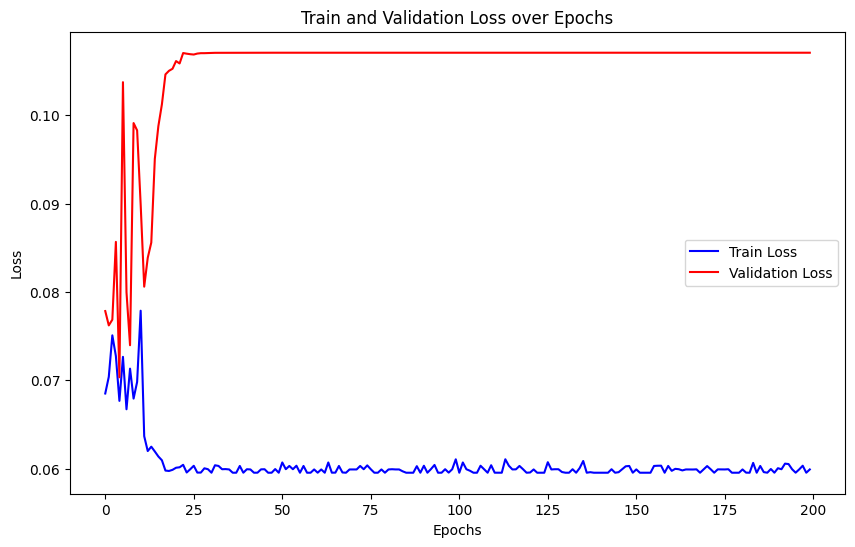

In [135]:
def plot_loss(history):
    train_losses = [x[0] for x in history]
    val_losses = [x[1] for x in history]

    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Train Loss', color='blue')
    plt.plot(val_losses, label='Validation Loss', color='red')

    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Train and Validation Loss over Epochs')
    plt.legend()

    plt.show()

plot_loss(history)

In [131]:
evaluate(model, val_loader)

Accuracy: 96.39%


In [133]:
test_data = pd.read_csv("../data/sample_submission.csv")
test_data.head()

,id,label
0,4a73abcd02.jpg,0
1,266bdb8d70.jpg,0
2,1389b9fb66.jpg,0
3,7e1c35f2e6.jpg,0
4,8271bebf8f.jpg,0


In [142]:
test_features = transformer(image_paths=[os.path.join("data", "test", path) for path in test_data.iloc[:, 0].values])

In [143]:
max_keypoints = 99
padded_keypoints = []
masks = []

for tensor in test_features:
    mask = torch.ones(max_keypoints)  
    
    if tensor.size(0) < max_keypoints:
        padding = torch.zeros(max_keypoints - tensor.size(0), dtype=torch.float32)
        tensor = torch.cat([tensor, padding], dim=0)
        mask[tensor.size(0):] = 0  
    
    padded_keypoints.append(tensor)
    masks.append(mask)

keypoints_tensor = torch.stack(padded_keypoints, dim=0)
mask_tensor = torch.stack(masks, dim=0)
labels = torch.tensor(test_data['label'].values)

In [145]:
keypoints_tensor.shape

torch.Size([2152, 99])

In [148]:
def predict(model, features, threshold=0.75):
    model.eval()  
    with torch.no_grad():  
        outputs = model(features)  
        predicted_label = (outputs > threshold).float()
    
    return predicted_label

In [150]:
predictions = predict(model, keypoints_tensor)

In [165]:
test_data['label'] = predictions.squeeze().int()

In [166]:
test_data.head()

,id,label
0,4a73abcd02.jpg,0
1,266bdb8d70.jpg,0
2,1389b9fb66.jpg,0
3,7e1c35f2e6.jpg,0
4,8271bebf8f.jpg,0


In [169]:
test_data['label'].sum()

635

In [173]:
test_data.to_csv("../data/submissions/006.csv", index=False)

In [172]:
pd.read_csv("../data/submissions/003.csv")['label'].sum()

763